In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

#contour = load_contour().to(device)
#contour.shape

torch.Size([3, 386, 3, 64, 64])

In [2]:
T = 500
beta = torch.linspace(50e-4, 0.02, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0018, device='cuda:0')

In [3]:
alpha_

tensor([0.9950, 0.9900, 0.9850, 0.9800, 0.9750, 0.9699, 0.9649, 0.9599, 0.9549,
        0.9498, 0.9448, 0.9397, 0.9347, 0.9297, 0.9246, 0.9196, 0.9146, 0.9095,
        0.9045, 0.8994, 0.8944, 0.8894, 0.8843, 0.8793, 0.8743, 0.8692, 0.8642,
        0.8592, 0.8542, 0.8491, 0.8441, 0.8391, 0.8341, 0.8291, 0.8241, 0.8191,
        0.8142, 0.8092, 0.8042, 0.7993, 0.7943, 0.7893, 0.7844, 0.7795, 0.7745,
        0.7696, 0.7647, 0.7598, 0.7549, 0.7500, 0.7451, 0.7403, 0.7354, 0.7306,
        0.7257, 0.7209, 0.7161, 0.7113, 0.7065, 0.7017, 0.6969, 0.6922, 0.6874,
        0.6827, 0.6779, 0.6732, 0.6685, 0.6638, 0.6592, 0.6545, 0.6498, 0.6452,
        0.6406, 0.6360, 0.6314, 0.6268, 0.6222, 0.6177, 0.6132, 0.6086, 0.6041,
        0.5996, 0.5952, 0.5907, 0.5862, 0.5818, 0.5774, 0.5730, 0.5686, 0.5643,
        0.5599, 0.5556, 0.5513, 0.5470, 0.5427, 0.5384, 0.5342, 0.5300, 0.5257,
        0.5216, 0.5174, 0.5132, 0.5091, 0.5050, 0.5009, 0.4968, 0.4927, 0.4887,
        0.4846, 0.4806, 0.4766, 0.4726, 

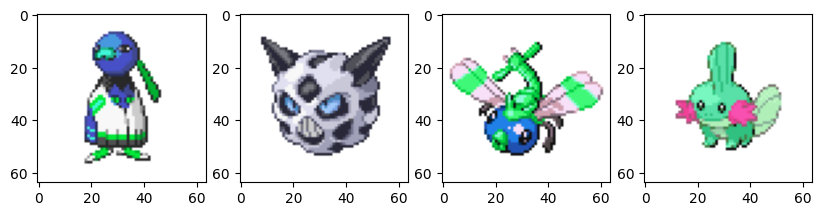

In [4]:
transform = v2.Compose([
    v2.ColorJitter(),
    v2.RandomChannelPermutation(),
    v2.RandomGrayscale(p = 0.1),
    #v2.GaussianBlur(kernel_size=9, sigma=(1,1))
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
pimages.min(), pimages.max()

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

In [6]:
def isigmoid(x):
    eps = 0.1
    return torch.log(x + eps) - torch.log(1 - x + eps)


In [7]:
model = UNet(3, 3).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    #cont = contour[1, 151]
    x = torch.randn((3,64,64), device=device)

    for t in reversed(range(T)):
        tt = torch.tensor(t, device=device)

        z = torch.randn((3,64,64), device=device)

        #xn = torch.cat([x, cont], dim=0)
        e = model(x[None], tt)[0] * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])

        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
        
    plot_image(torch.sigmoid(x))
    plt.show()

    model.train()

  0%|                                                                                                                                       | 0/100001 [00:00<?, ?it/s]

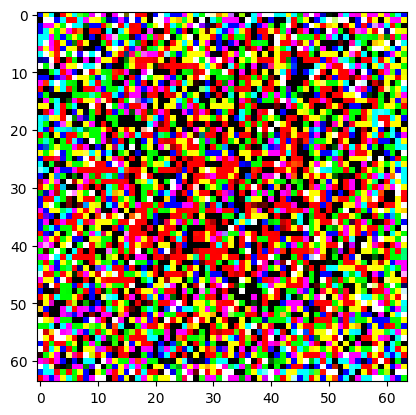

0.06181838:   1%|█                                                                                                              | 999/100001 [01:18<2:05:43, 13.12it/s]

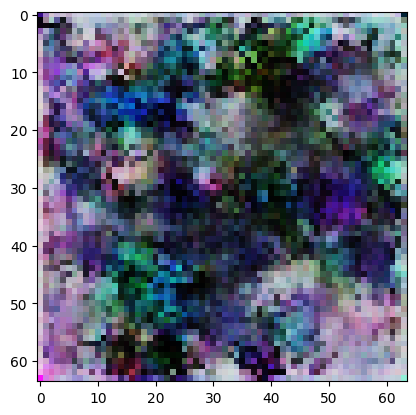

0.06317487:   2%|██▏                                                                                                           | 1999/100001 [02:38<2:04:52, 13.08it/s]

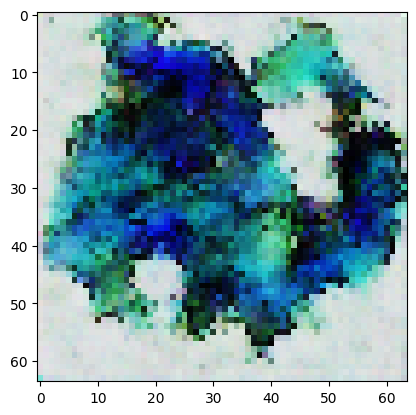

0.04573961:   3%|███▎                                                                                                          | 2999/100001 [03:57<2:03:23, 13.10it/s]

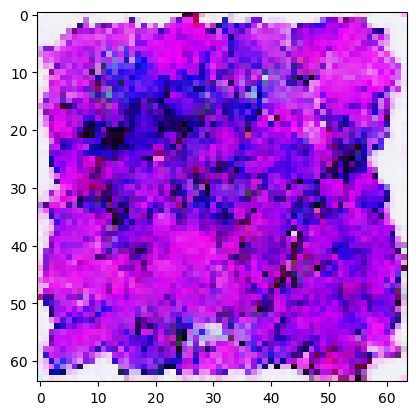

0.09039637:   4%|████▍                                                                                                         | 3999/100001 [05:16<2:02:06, 13.10it/s]

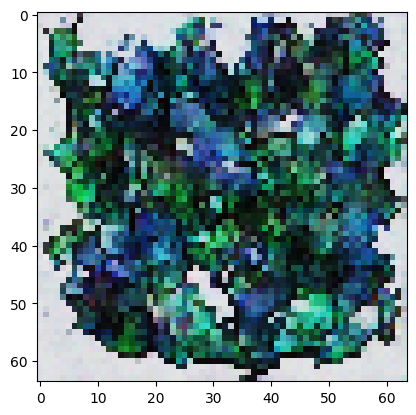

0.03761620:   5%|█████▍                                                                                                        | 4999/100001 [06:35<2:00:50, 13.10it/s]

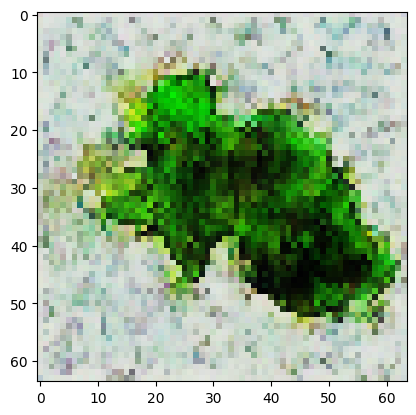

0.05959855:   6%|██████▌                                                                                                       | 5999/100001 [07:54<1:59:36, 13.10it/s]

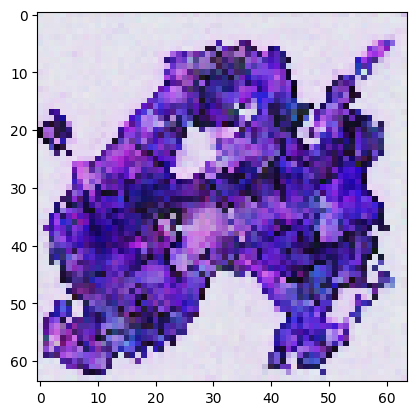

0.06723246:   7%|███████▋                                                                                                      | 6999/100001 [09:14<1:58:14, 13.11it/s]

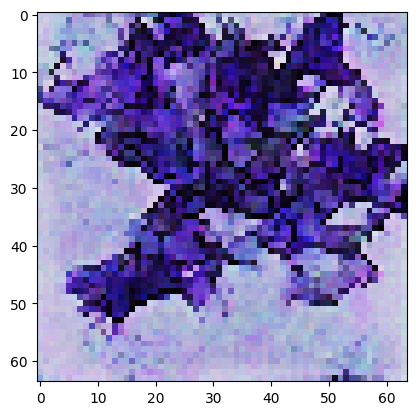

0.05436563:   8%|████████▊                                                                                                     | 7999/100001 [10:33<1:56:49, 13.13it/s]

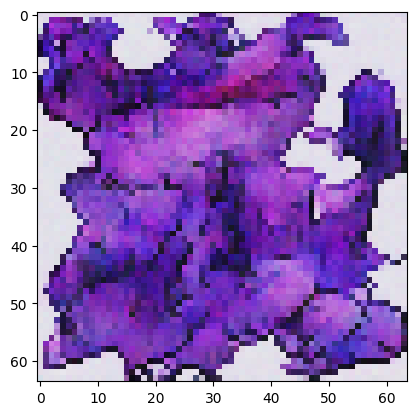

0.03714766:   9%|█████████▉                                                                                                    | 8999/100001 [11:52<1:55:38, 13.11it/s]

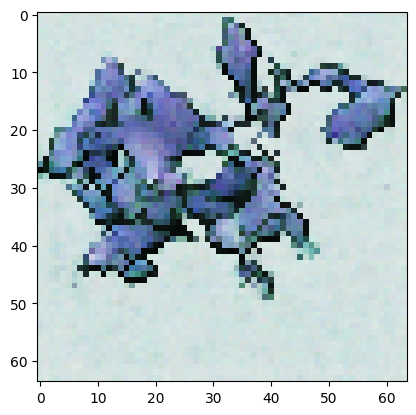

0.04593368:  10%|██████████▉                                                                                                   | 9999/100001 [13:11<1:54:20, 13.12it/s]

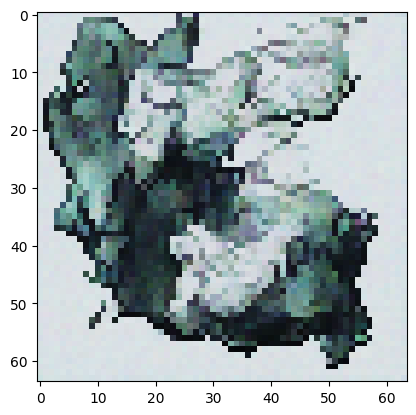

0.03883356:  11%|███████████▉                                                                                                 | 10999/100001 [14:30<1:52:33, 13.18it/s]

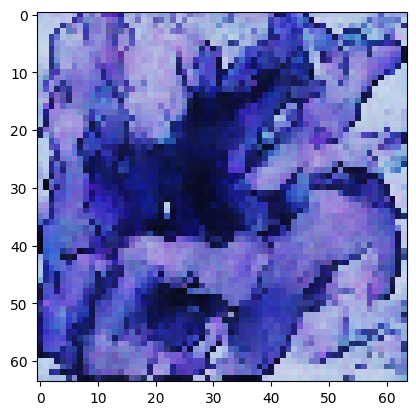

0.03463772:  12%|█████████████                                                                                                | 11999/100001 [15:49<1:51:48, 13.12it/s]

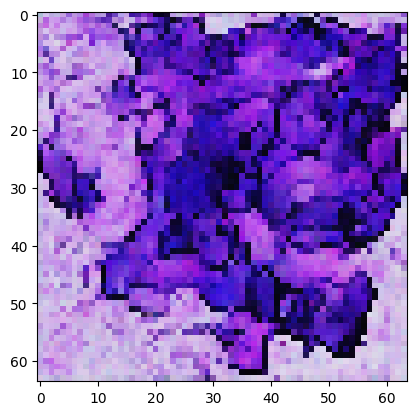

0.03499701:  13%|██████████████▏                                                                                              | 12999/100001 [17:08<1:50:37, 13.11it/s]

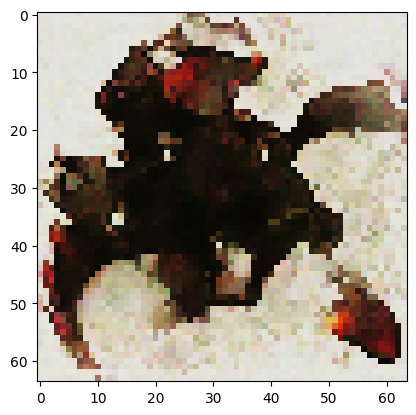

0.04262827:  14%|███████████████▎                                                                                             | 13999/100001 [18:28<1:49:27, 13.10it/s]

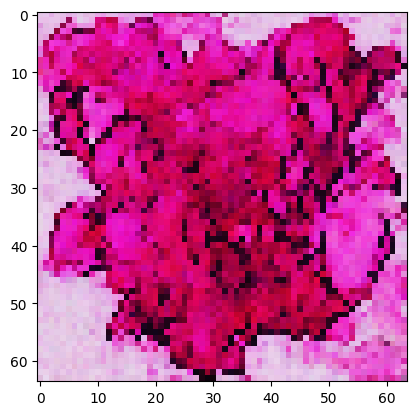

0.05558056:  15%|████████████████▎                                                                                            | 14999/100001 [19:47<1:48:07, 13.10it/s]

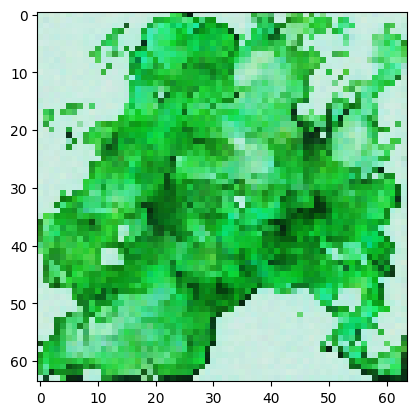

0.04618131:  16%|█████████████████▍                                                                                           | 15999/100001 [21:06<1:47:01, 13.08it/s]

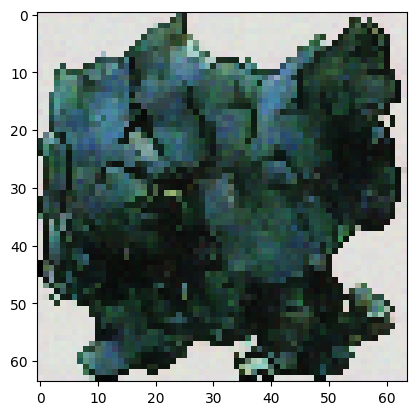

0.04804435:  17%|██████████████████▌                                                                                          | 16999/100001 [22:25<1:45:36, 13.10it/s]

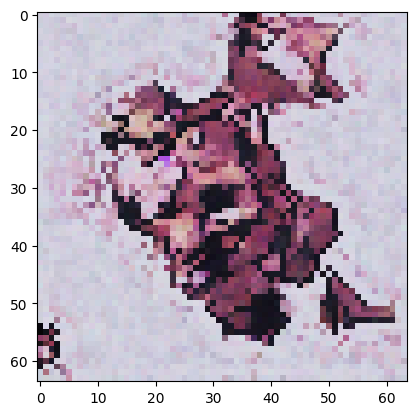

0.03316132:  18%|███████████████████▌                                                                                         | 17999/100001 [23:44<1:44:12, 13.12it/s]

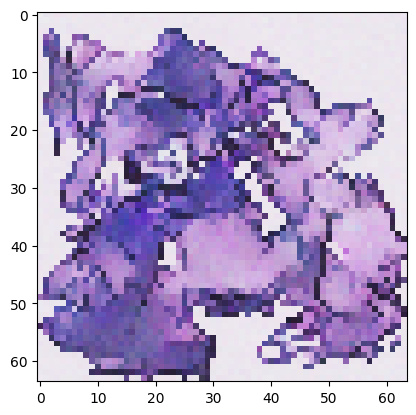

0.04504828:  19%|████████████████████▋                                                                                        | 18999/100001 [25:04<1:43:46, 13.01it/s]

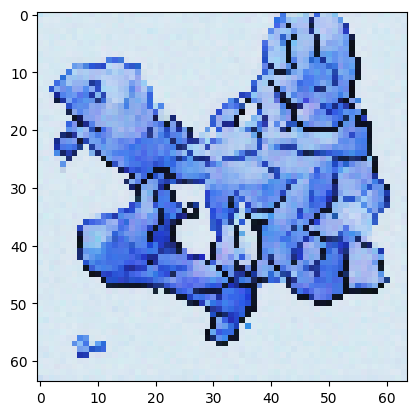

0.03267435:  20%|█████████████████████▊                                                                                       | 19999/100001 [26:23<1:41:42, 13.11it/s]

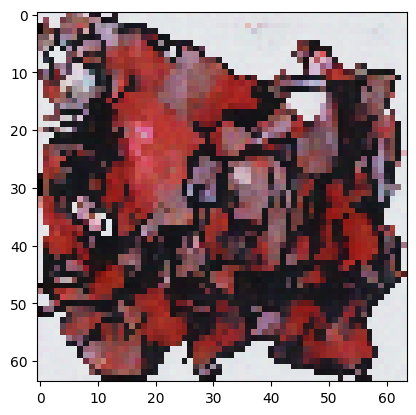

0.03470391:  21%|██████████████████████▉                                                                                      | 20999/100001 [27:43<1:40:34, 13.09it/s]

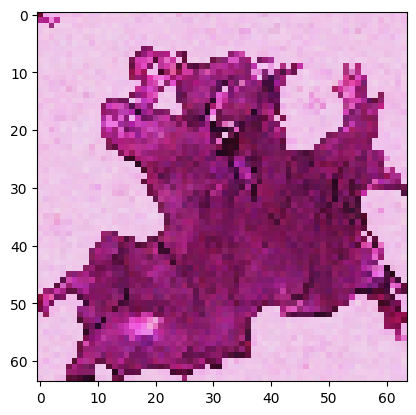

0.05130516:  22%|███████████████████████▉                                                                                     | 21999/100001 [29:02<1:39:06, 13.12it/s]

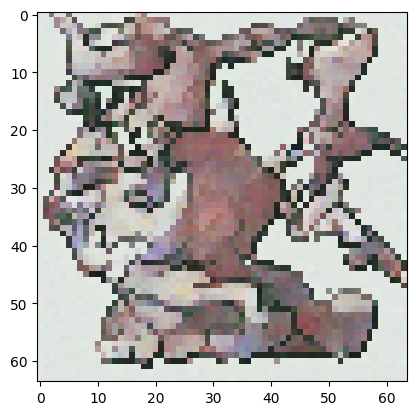

0.04134108:  23%|█████████████████████████                                                                                    | 22999/100001 [30:21<1:37:57, 13.10it/s]

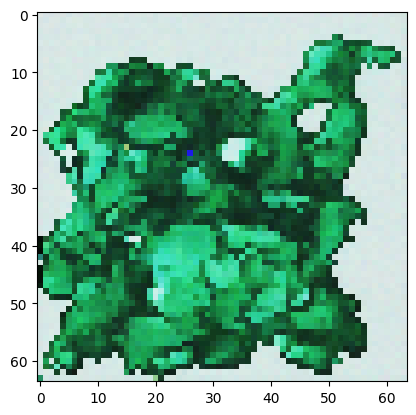

0.04274878:  24%|██████████████████████████▏                                                                                  | 23999/100001 [31:40<1:36:31, 13.12it/s]

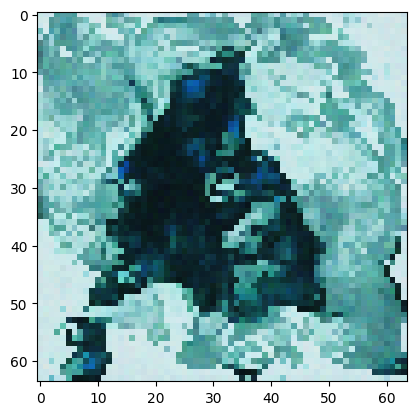

0.02242557:  25%|███████████████████████████▏                                                                                 | 24999/100001 [33:00<1:35:21, 13.11it/s]

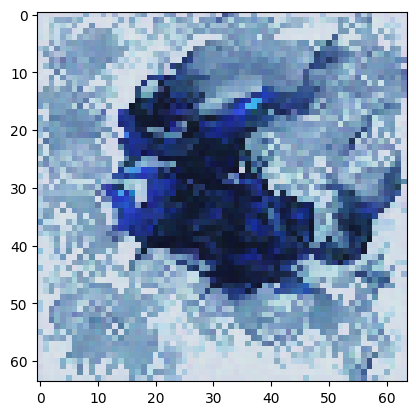

0.03513810:  26%|████████████████████████████▎                                                                                | 25999/100001 [34:25<1:56:26, 10.59it/s]

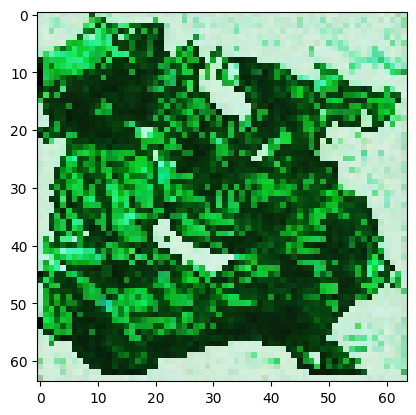

0.03431810:  27%|█████████████████████████████▍                                                                               | 26999/100001 [35:45<1:32:52, 13.10it/s]

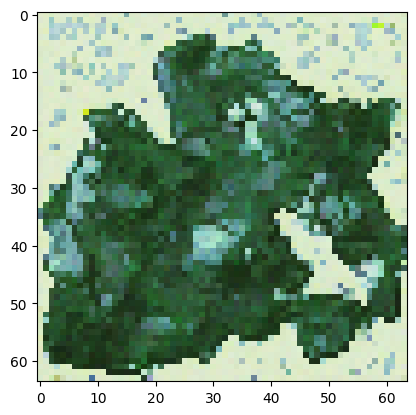

0.03123817:  28%|██████████████████████████████▌                                                                              | 27999/100001 [37:17<1:31:42, 13.09it/s]

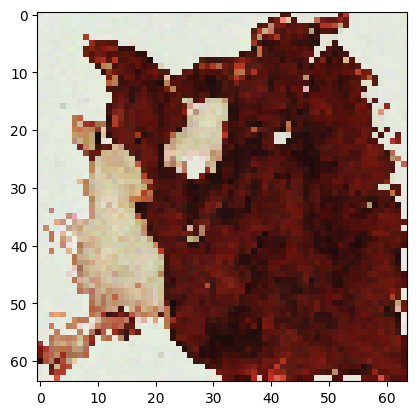

0.01915555:  29%|███████████████████████████████▌                                                                             | 28999/100001 [38:36<1:30:19, 13.10it/s]

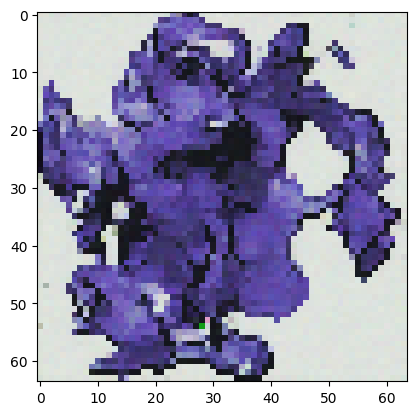

0.02126306:  30%|████████████████████████████████▋                                                                            | 29999/100001 [39:55<1:28:45, 13.14it/s]

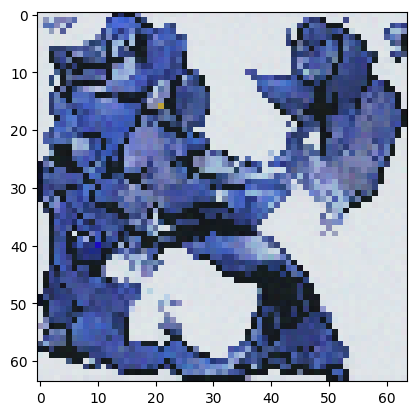

0.05142707:  31%|█████████████████████████████████▊                                                                           | 30999/100001 [41:15<1:27:39, 13.12it/s]

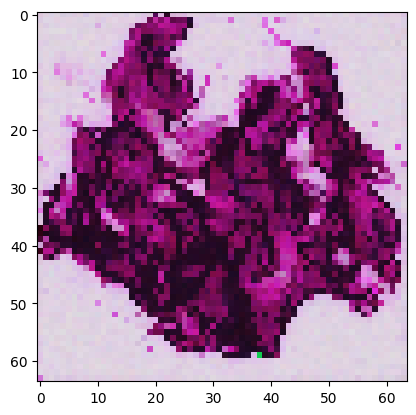

0.03967277:  32%|██████████████████████████████████▉                                                                          | 31999/100001 [42:34<1:26:43, 13.07it/s]

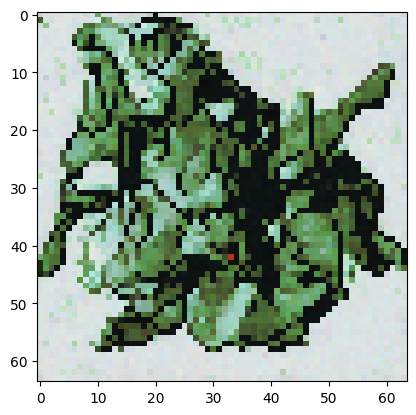

0.03751915:  33%|███████████████████████████████████▉                                                                         | 32999/100001 [43:53<1:25:11, 13.11it/s]

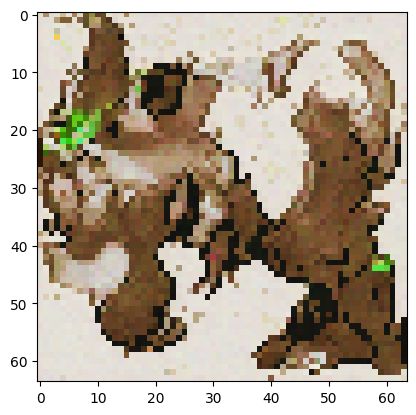

0.02517680:  34%|█████████████████████████████████████                                                                        | 33999/100001 [45:12<1:24:00, 13.09it/s]

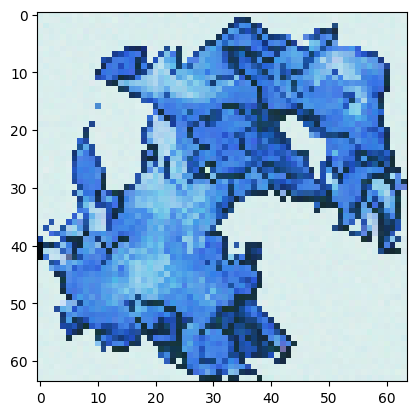

0.03115773:  35%|██████████████████████████████████████▏                                                                      | 34999/100001 [46:32<1:22:39, 13.11it/s]

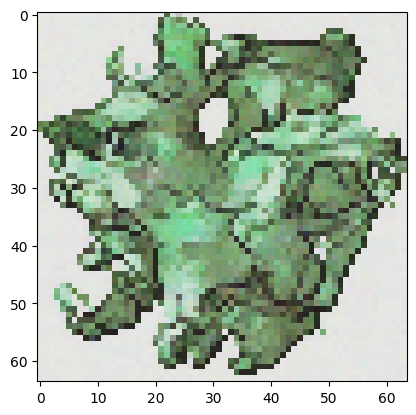

0.01658988:  36%|███████████████████████████████████████▏                                                                     | 35999/100001 [47:51<1:21:16, 13.12it/s]

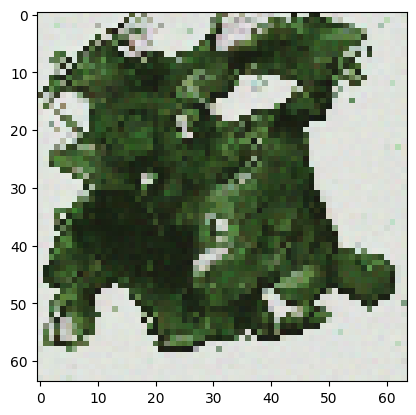

0.03379220:  37%|████████████████████████████████████████▎                                                                    | 36999/100001 [49:10<1:19:57, 13.13it/s]

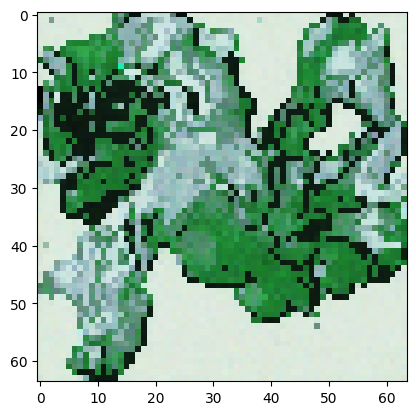

0.03342114:  38%|█████████████████████████████████████████▍                                                                   | 37999/100001 [50:29<1:18:46, 13.12it/s]

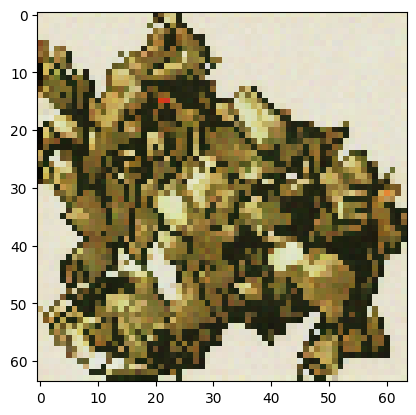

0.03083232:  39%|██████████████████████████████████████████▌                                                                  | 38999/100001 [51:48<1:17:31, 13.11it/s]

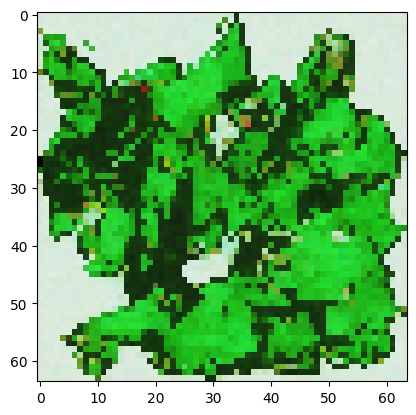

0.03468758:  40%|███████████████████████████████████████████▌                                                                 | 39999/100001 [53:07<1:16:12, 13.12it/s]

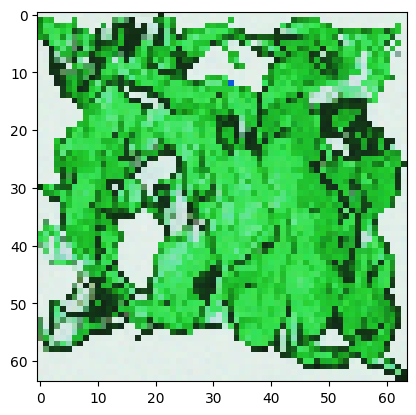

0.02857306:  41%|████████████████████████████████████████████▋                                                                | 40999/100001 [54:30<1:33:00, 10.57it/s]

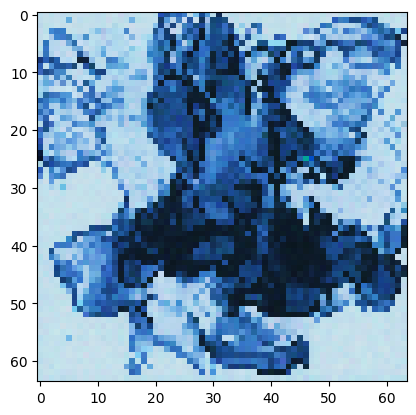

0.03556909:  42%|█████████████████████████████████████████████▊                                                               | 41999/100001 [56:05<1:29:50, 10.76it/s]

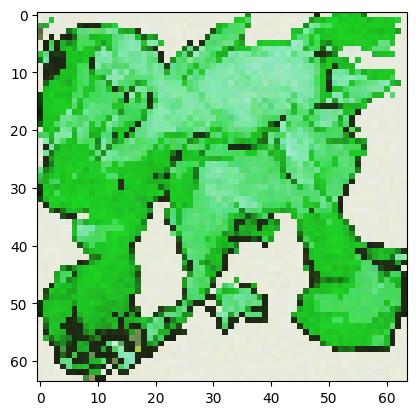

0.02524529:  43%|██████████████████████████████████████████████▊                                                              | 42999/100001 [57:40<1:29:34, 10.61it/s]

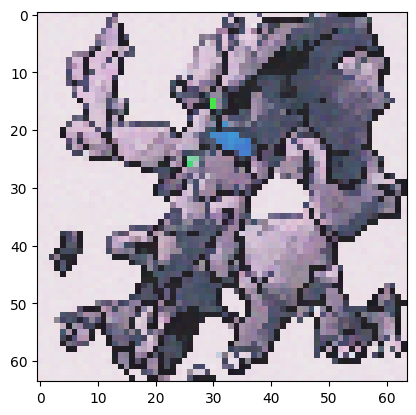

0.02563228:  44%|███████████████████████████████████████████████▉                                                             | 43999/100001 [59:15<1:27:20, 10.69it/s]

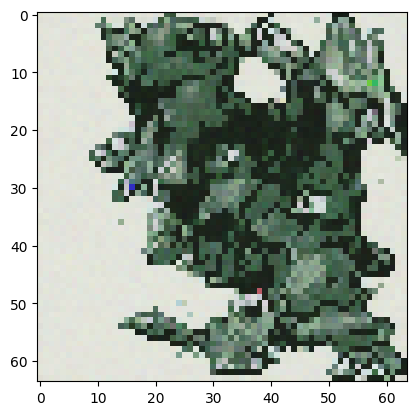

0.03300908:  45%|████████████████████████████████████████████████▏                                                          | 44999/100001 [1:00:50<1:26:31, 10.59it/s]

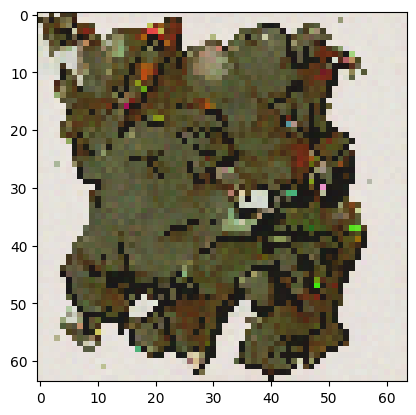

0.02961843:  46%|█████████████████████████████████████████████████▏                                                         | 45999/100001 [1:02:25<1:24:17, 10.68it/s]

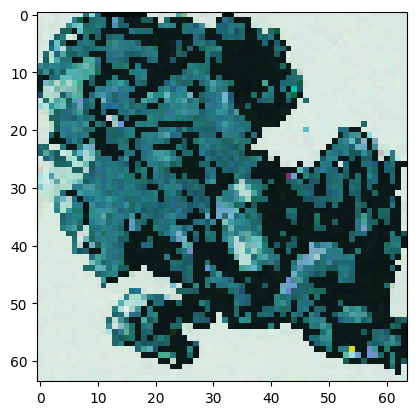

0.03661541:  47%|██████████████████████████████████████████████████▎                                                        | 46999/100001 [1:04:01<1:23:20, 10.60it/s]

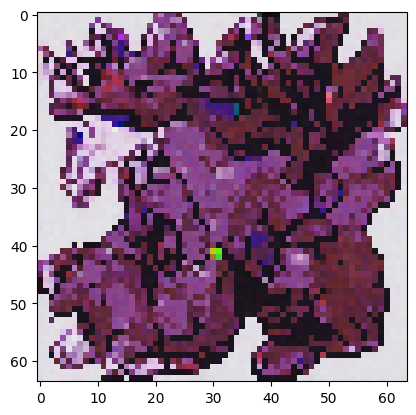

0.01880626:  48%|███████████████████████████████████████████████████▎                                                       | 47999/100001 [1:05:36<1:20:14, 10.80it/s]

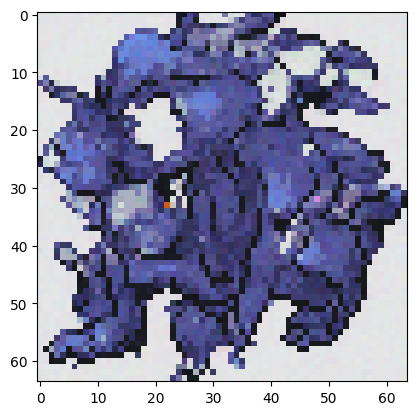

0.05419203:  49%|████████████████████████████████████████████████████▍                                                      | 48999/100001 [1:07:07<1:04:51, 13.11it/s]

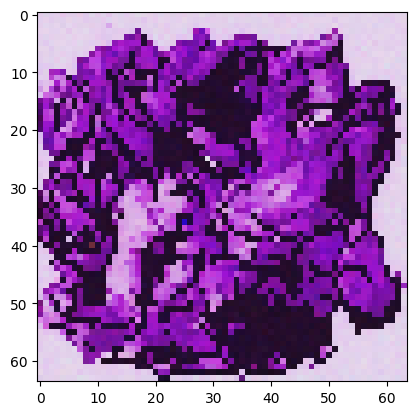

0.03210091:  50%|█████████████████████████████████████████████████████▍                                                     | 49999/100001 [1:08:26<1:03:25, 13.14it/s]

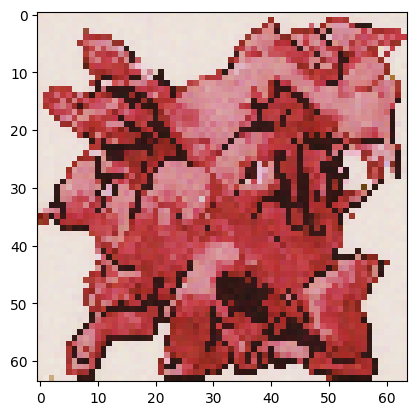

0.02518912:  51%|██████████████████████████████████████████████████████▌                                                    | 50999/100001 [1:09:45<1:02:07, 13.15it/s]

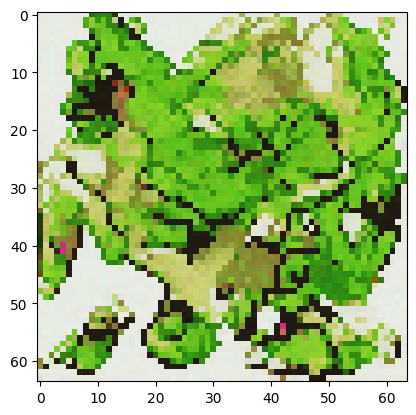

0.04129770:  52%|███████████████████████████████████████████████████████▋                                                   | 51999/100001 [1:11:04<1:00:54, 13.14it/s]

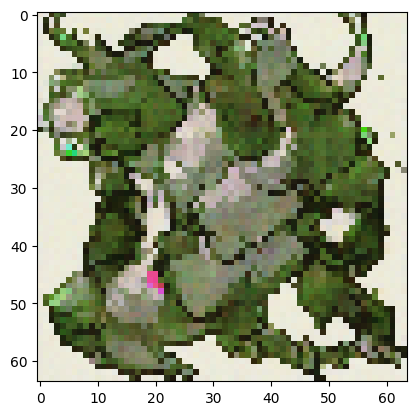

0.03387866:  53%|█████████████████████████████████████████████████████████▊                                                   | 52999/100001 [1:12:23<59:40, 13.13it/s]

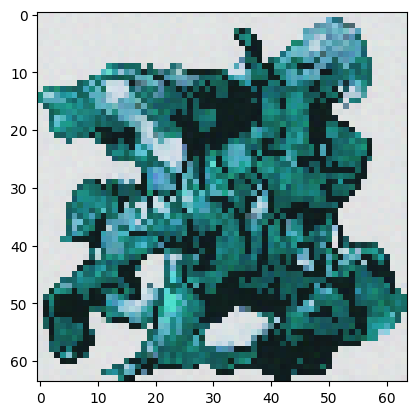

0.02344835:  54%|██████████████████████████████████████████████████████████▊                                                  | 53999/100001 [1:13:43<58:21, 13.14it/s]

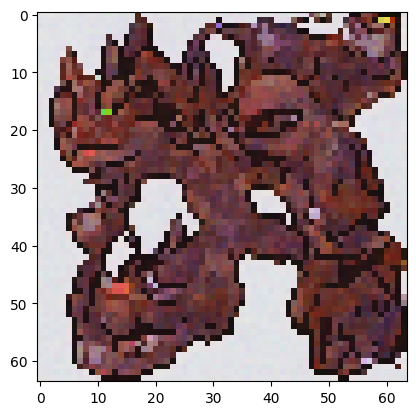

0.03530921:  55%|███████████████████████████████████████████████████████████▉                                                 | 54999/100001 [1:15:02<57:15, 13.10it/s]

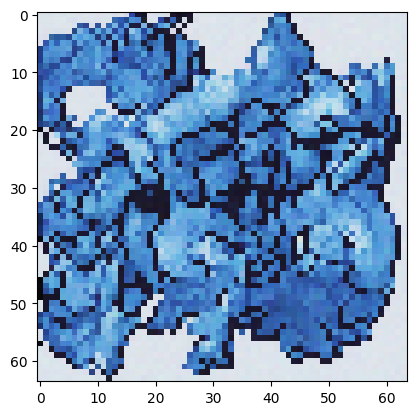

0.02700624:  56%|█████████████████████████████████████████████████████████████                                                | 55999/100001 [1:16:21<55:53, 13.12it/s]

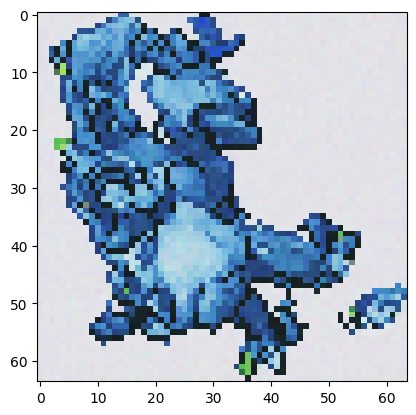

0.03710929:  57%|████████████████████████████████████████████████████████████▉                                              | 56999/100001 [1:17:44<1:08:03, 10.53it/s]

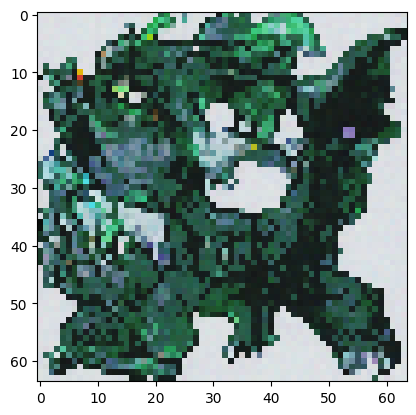

0.02621099:  58%|███████████████████████████████████████████████████████████████▏                                             | 57999/100001 [1:19:12<53:26, 13.10it/s]

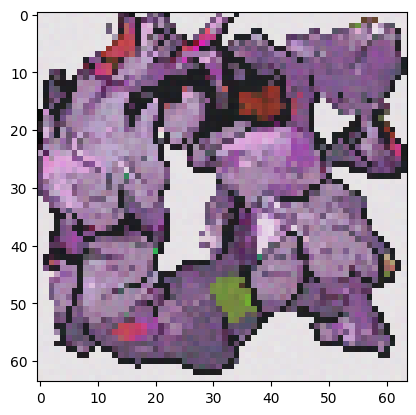

0.02634525:  59%|████████████████████████████████████████████████████████████████▎                                            | 58999/100001 [1:20:31<51:52, 13.17it/s]

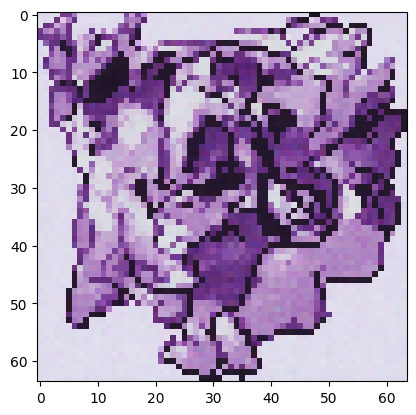

0.03284593:  60%|█████████████████████████████████████████████████████████████████▍                                           | 59999/100001 [1:21:49<50:44, 13.14it/s]

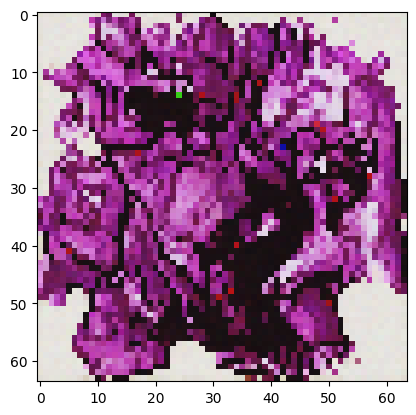

0.02540451:  61%|██████████████████████████████████████████████████████████████████▍                                          | 60999/100001 [1:23:09<49:30, 13.13it/s]

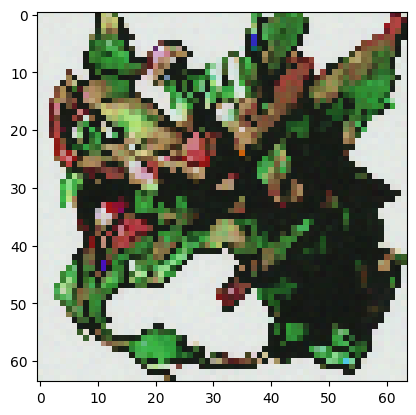

0.03910079:  62%|███████████████████████████████████████████████████████████████████▌                                         | 61999/100001 [1:24:28<48:16, 13.12it/s]

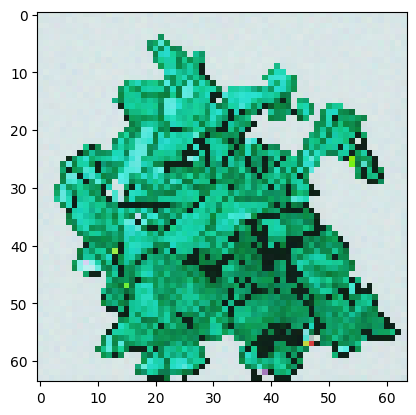

0.02494921:  63%|████████████████████████████████████████████████████████████████████▋                                        | 62999/100001 [1:25:47<47:00, 13.12it/s]

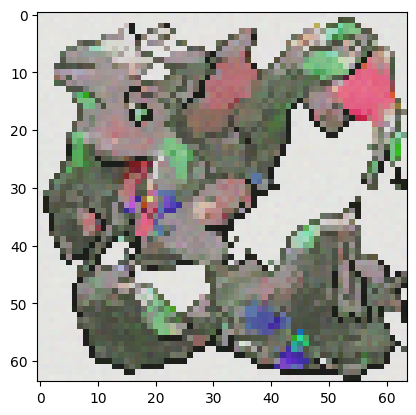

0.03575649:  64%|█████████████████████████████████████████████████████████████████████▊                                       | 63999/100001 [1:27:06<45:38, 13.15it/s]

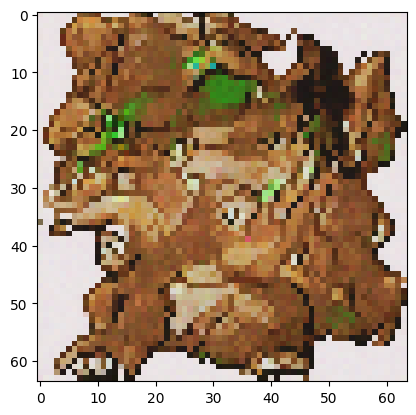

0.02444730:  65%|██████████████████████████████████████████████████████████████████████▊                                      | 64999/100001 [1:28:25<44:28, 13.12it/s]

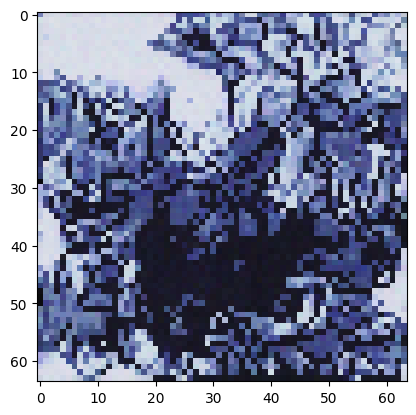

0.03395064:  66%|███████████████████████████████████████████████████████████████████████▉                                     | 65999/100001 [1:29:44<43:11, 13.12it/s]

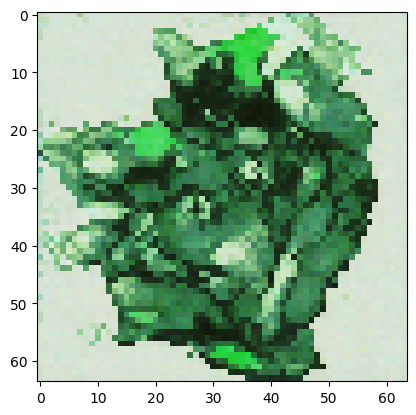

0.03281859:  67%|█████████████████████████████████████████████████████████████████████████                                    | 66999/100001 [1:31:03<41:53, 13.13it/s]

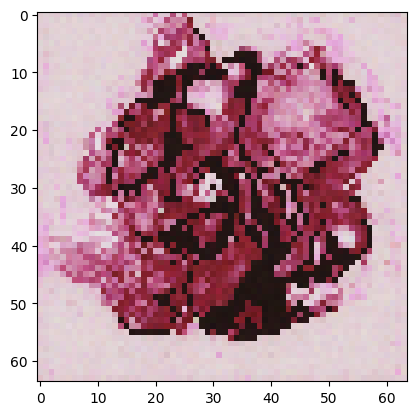

0.02392822:  68%|██████████████████████████████████████████████████████████████████████████                                   | 67999/100001 [1:32:22<40:42, 13.10it/s]

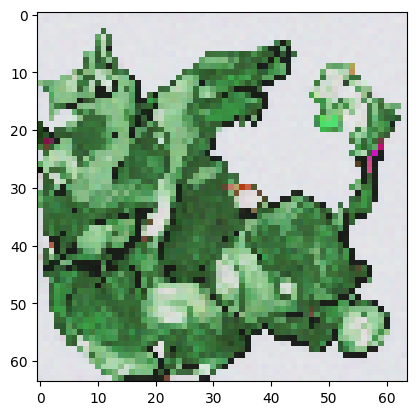

0.01982290:  69%|███████████████████████████████████████████████████████████████████████████▏                                 | 68999/100001 [1:33:41<39:18, 13.15it/s]

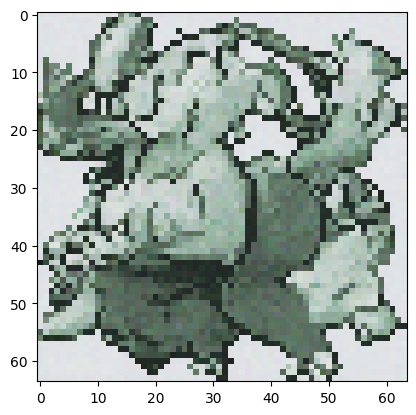

0.02768200:  70%|████████████████████████████████████████████████████████████████████████████▎                                | 69999/100001 [1:35:00<38:07, 13.12it/s]

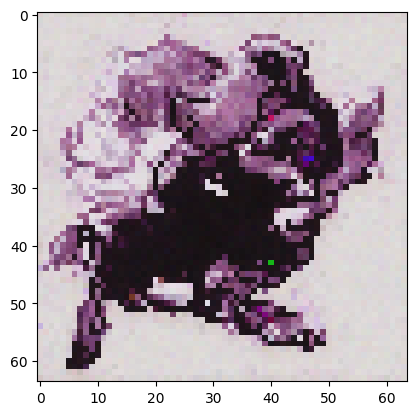

0.03016789:  71%|█████████████████████████████████████████████████████████████████████████████▍                               | 70999/100001 [1:36:19<36:52, 13.11it/s]

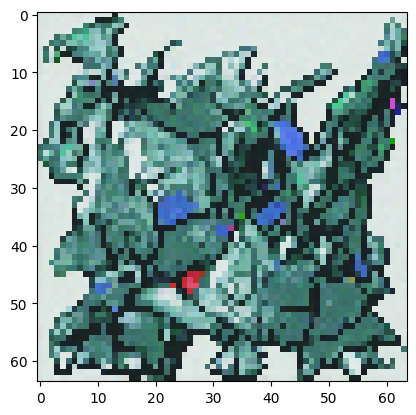

0.02603180:  72%|██████████████████████████████████████████████████████████████████████████████▍                              | 71999/100001 [1:37:39<35:35, 13.11it/s]

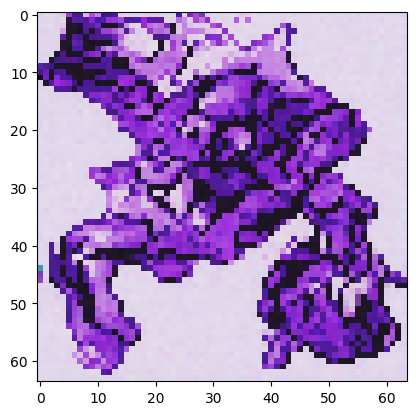

0.02085383:  73%|███████████████████████████████████████████████████████████████████████████████▌                             | 72999/100001 [1:38:58<34:16, 13.13it/s]

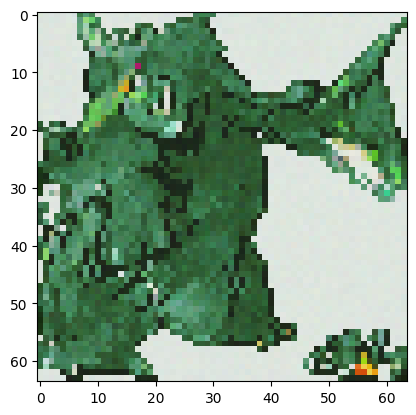

0.03448281:  74%|████████████████████████████████████████████████████████████████████████████████▋                            | 73999/100001 [1:40:17<33:03, 13.11it/s]

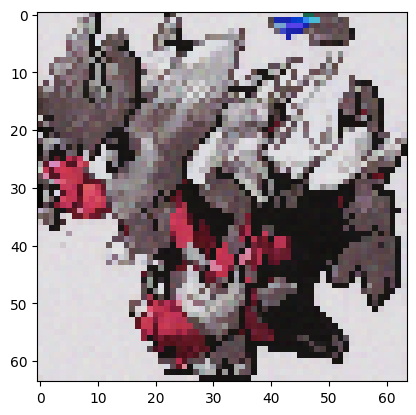

0.04588765:  75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 74999/100001 [1:41:36<31:46, 13.11it/s]

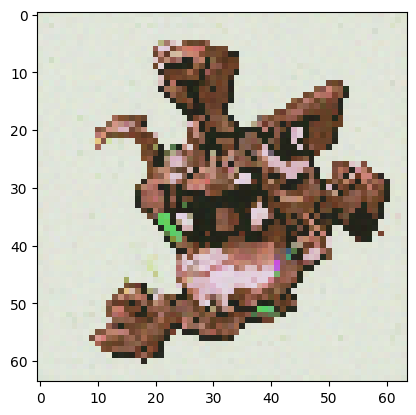

0.01919352:  76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 75999/100001 [1:42:55<30:23, 13.16it/s]

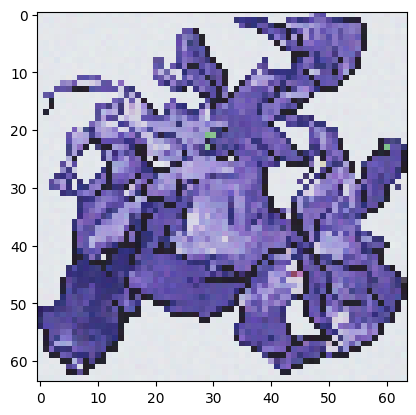

0.02012924:  77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 76999/100001 [1:44:14<29:13, 13.12it/s]

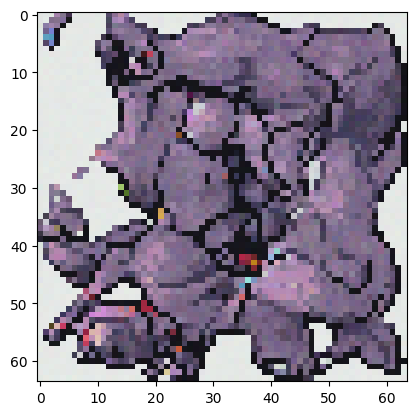

0.05021856:  78%|█████████████████████████████████████████████████████████████████████████████████████                        | 77999/100001 [1:45:33<27:55, 13.13it/s]

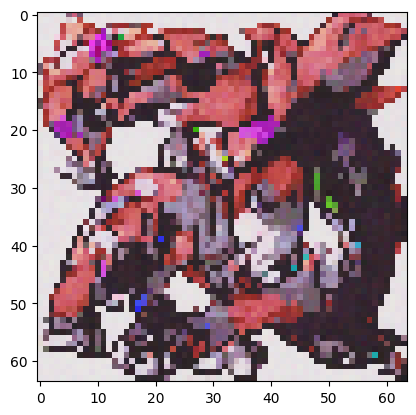

0.03675085:  79%|██████████████████████████████████████████████████████████████████████████████████████                       | 78999/100001 [1:46:52<26:38, 13.13it/s]

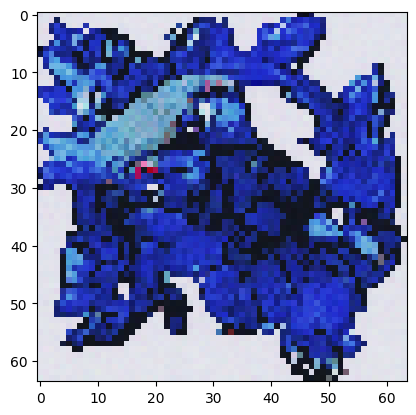

0.02983591:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 79999/100001 [1:48:11<25:24, 13.12it/s]

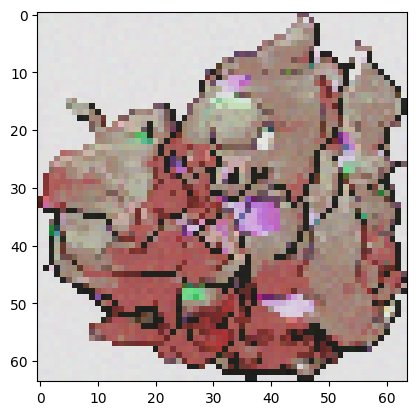

0.02903632:  81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 80999/100001 [1:49:30<24:07, 13.13it/s]

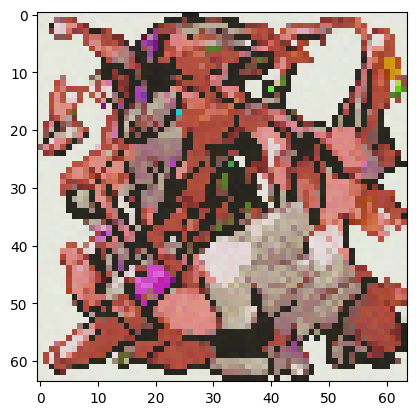

0.01853597:  82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 81999/100001 [1:50:50<22:51, 13.13it/s]

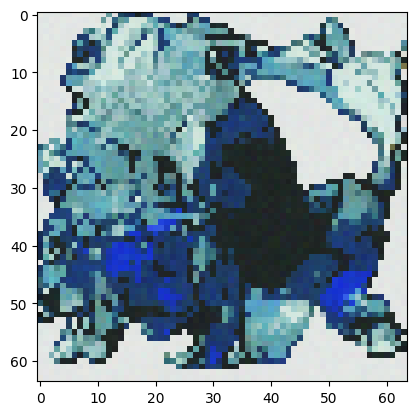

0.02252824:  83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 82999/100001 [1:52:09<21:35, 13.13it/s]

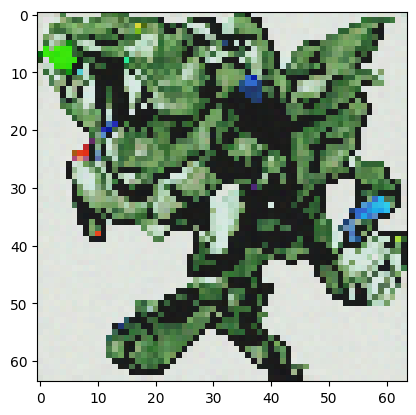

0.02885832:  84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 83999/100001 [1:53:28<20:20, 13.12it/s]

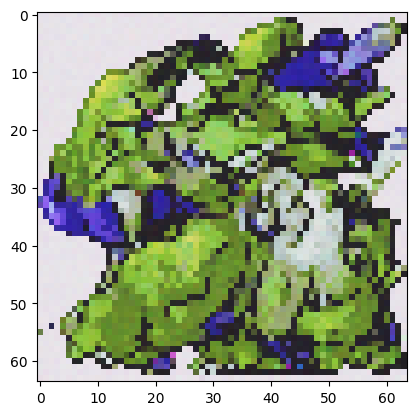

0.03648089:  85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 84999/100001 [1:54:47<19:02, 13.13it/s]

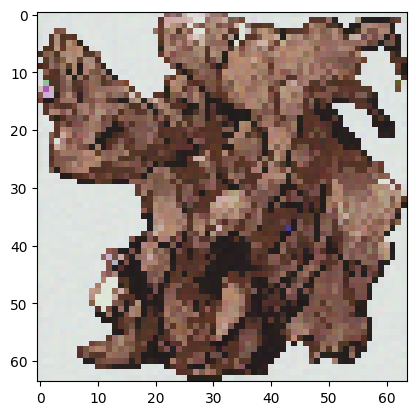

0.02388348:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 85999/100001 [1:56:06<17:47, 13.12it/s]

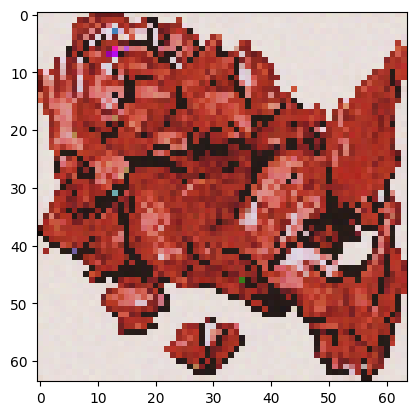

0.02118421:  87%|██████████████████████████████████████████████████████████████████████████████████████████████▊              | 86999/100001 [1:57:25<16:30, 13.13it/s]

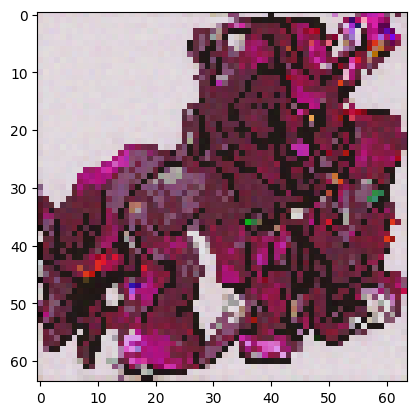

0.03248043:  88%|███████████████████████████████████████████████████████████████████████████████████████████████▉             | 87999/100001 [1:58:58<18:34, 10.77it/s]

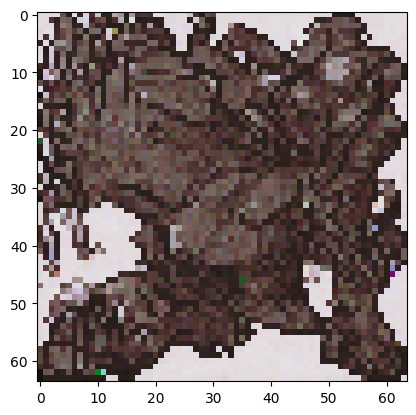

0.02509018:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 88999/100001 [2:00:28<17:29, 10.48it/s]

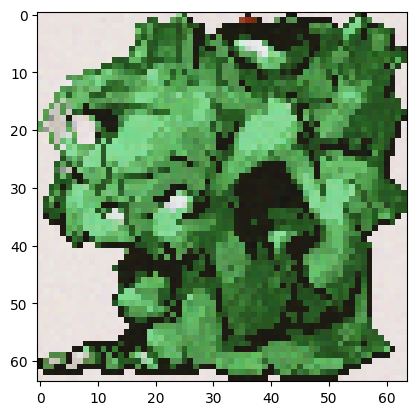

0.02026449:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 89999/100001 [2:01:48<12:41, 13.13it/s]

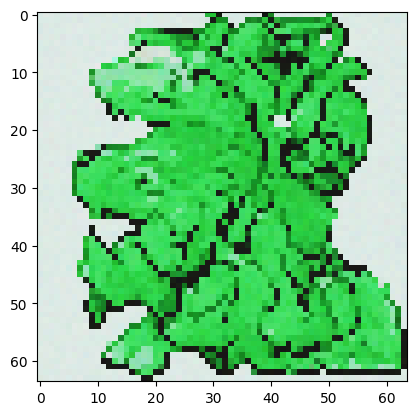

0.03387241:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 90999/100001 [2:03:07<11:27, 13.10it/s]

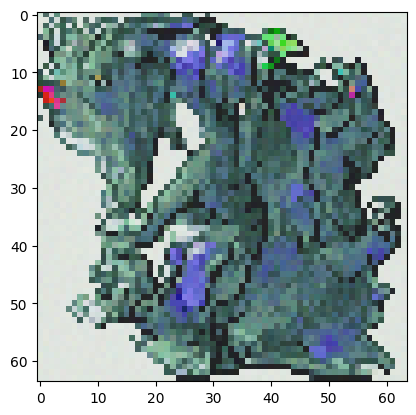

0.02979469:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 91999/100001 [2:04:26<10:10, 13.10it/s]

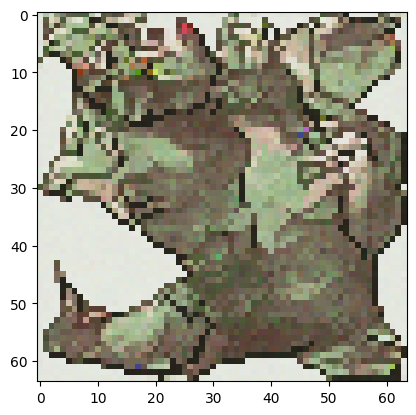

0.01449621:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 92999/100001 [2:05:46<08:55, 13.09it/s]

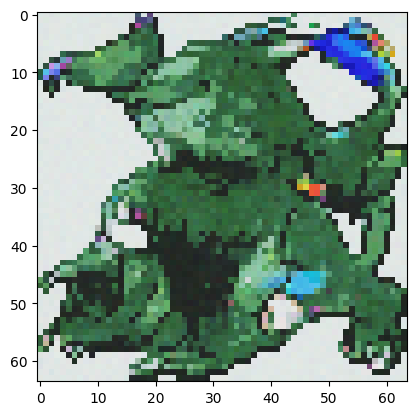

0.01821256:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 93999/100001 [2:07:05<07:43, 12.96it/s]

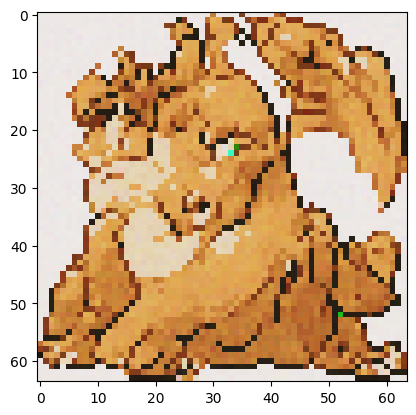

0.03711753:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 94999/100001 [2:08:26<06:23, 13.06it/s]

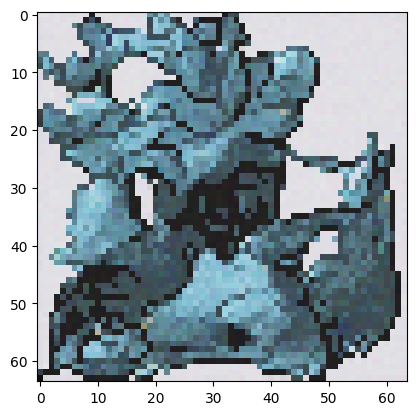

0.03758186:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 95999/100001 [2:09:46<05:05, 13.08it/s]

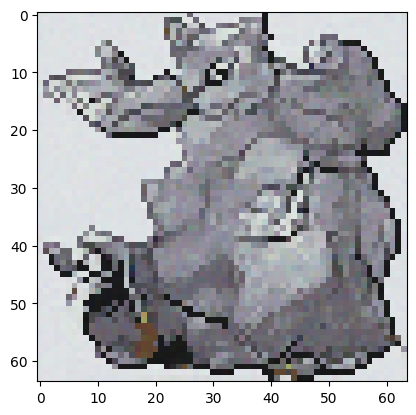

0.03330076:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 96999/100001 [2:11:06<03:50, 13.03it/s]

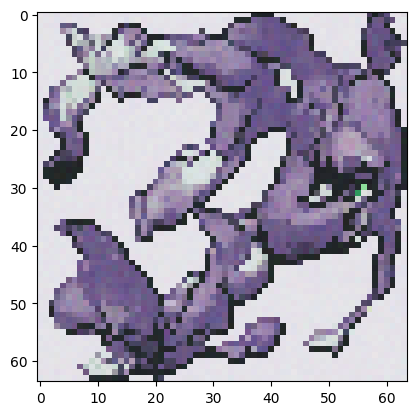

0.03437905:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 97999/100001 [2:12:25<02:32, 13.14it/s]

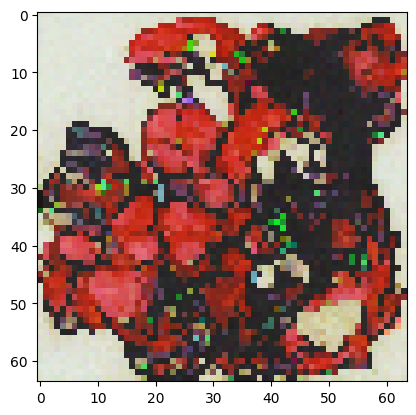

0.03079967:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 98999/100001 [2:13:44<01:16, 13.05it/s]

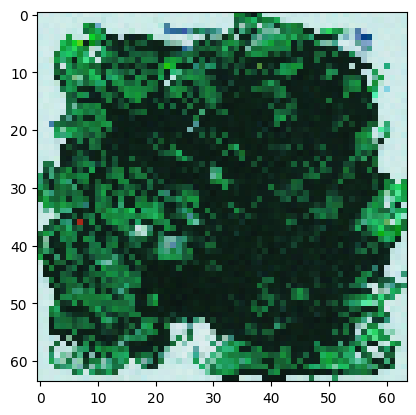

0.04802891: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 99999/100001 [2:15:04<00:00, 13.09it/s]

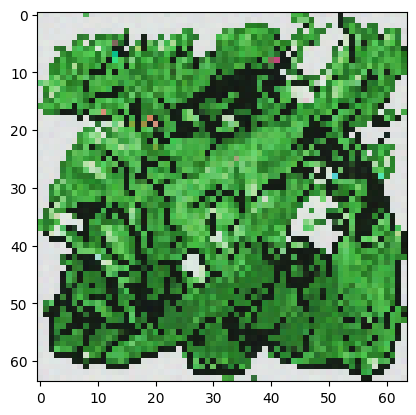

0.01932103: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100001/100001 [2:15:07<00:00, 12.33it/s]


In [8]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(100001))#, miniters=15)
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)
    
    e = torch.randn(x0.shape, device=device)
    t = torch.randint(0, T - 1, (bs,), device=device)

    x_nois = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    #xc = contour[source, batch]
    #xn = torch.cat([x_nois, xc], dim=1)

    e_pred = model(x_nois, t)

    # Calculate the loss between the result and the noise
    loss = loss_func(e, e_pred)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')